L'objectif de ce dataset est de classifier des clients en 7 categories distinctes. Toutefois l'exercice n'est pas ici de produire le meilleur modele mais de produire un pipeline en utilisant les fonctions sklearn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

# Data Analysis

In [3]:
train_set.shape

(8068, 11)

In [4]:
train_set.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


<AxesSubplot:>

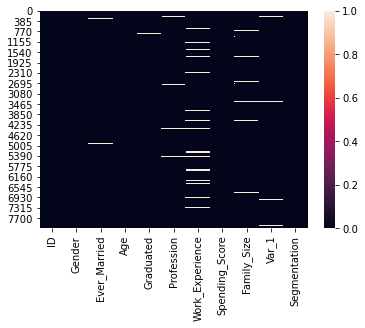

In [5]:
sns.heatmap(train_set.isna())

<AxesSubplot:ylabel='None'>

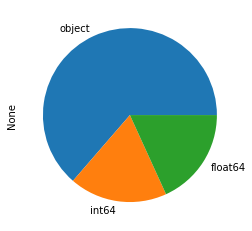

In [7]:
train_set.dtypes.value_counts().plot.pie()

In [8]:
train_set = train_set.drop('ID', axis = 1)
test_set = test_set.drop('ID', axis = 1)

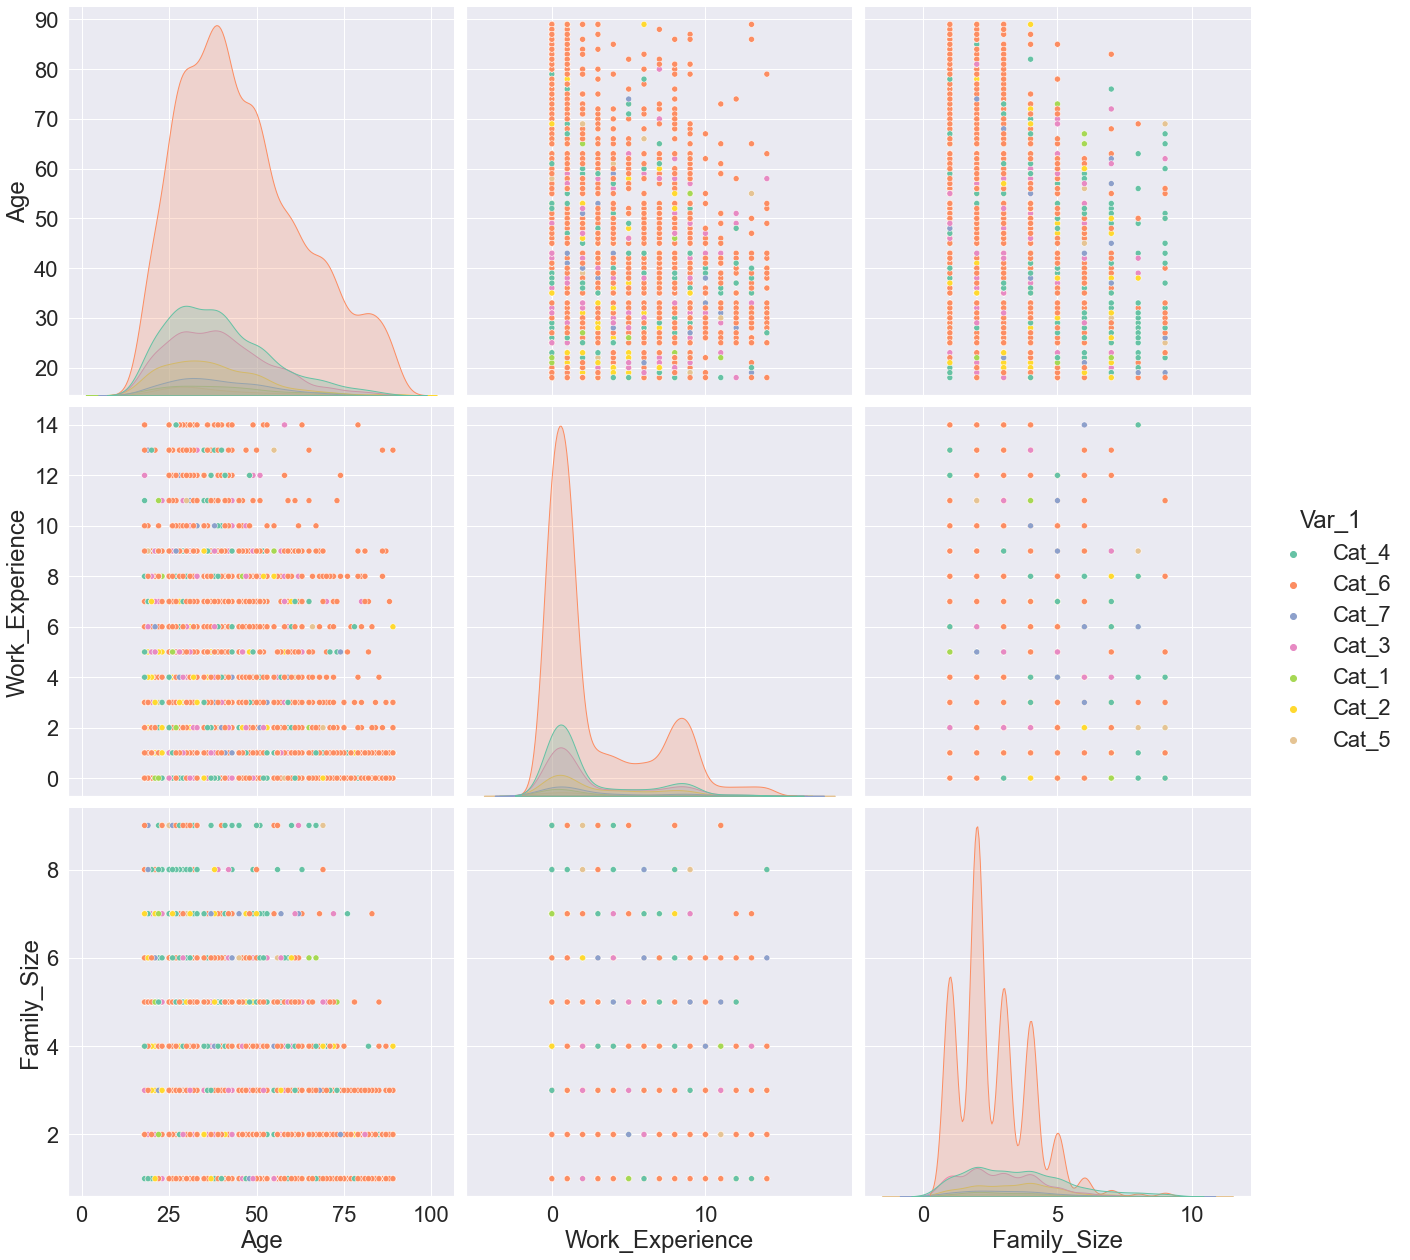

In [9]:
sns.set(font_scale=2)
sns.pairplot(data = train_set, hue = 'Var_1', palette = 'Set2', height = 6)

# Data Preprocessing

In [10]:
X_train = train_set.drop('Var_1', axis = 1)
y_train = train_set['Var_1'].astype(str)

X_test = test_set.drop('Var_1', axis = 1)
y_test = test_set['Var_1'].astype(str)

In [11]:
numerical_features = ['Age', 'Work_Experience', 'Family_Size']
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Work_Experience']
ordinal_features = ['Spending_Score', 'Segmentation']

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer


numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=10), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
ordinal_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                       (categorical_pipeline, categorical_features),
                                       (ordinal_pipeline, ordinal_features))

y_train_encoded = LabelEncoder().fit_transform(y_train)

In [13]:
X_train_encoded = preprocessor.fit_transform(X_train)

# Model implementation

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

model = make_pipeline(preprocessor, SVC())
model.fit(X_train, y_train_encoded)

model2 = make_pipeline(preprocessor, LogisticRegression())
model2.fit(X_train, y_train_encoded)

# Testing the models
y_test_encoded = LabelEncoder().fit_transform(y_test)
print('SVC : '+str(model.score(X_test, y_test_encoded)))
print('Logistic Regression : '+str(model2.score(X_test, y_test_encoded)))

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC : 0.6463646745336886
Logistic Regression : 0.6414160639512753


In [15]:
from sklearn.model_selection import GridSearchCV
params = {
    'logisticregression__max_iter': [1000, 5000],
}

grid = GridSearchCV(model2, param_grid=params, cv=5)
grid.fit(X_train, y_train_encoded)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer(n_neighbors=10)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Work_Experience',
                                                                          'Family_Size']),
                                                                        ('pipeline-2',
                                       

In [16]:
grid.score(X_test,y_test_encoded)

0.6410354015987819

In [17]:
print(grid.best_params_)

{'logisticregression__max_iter': 1000}


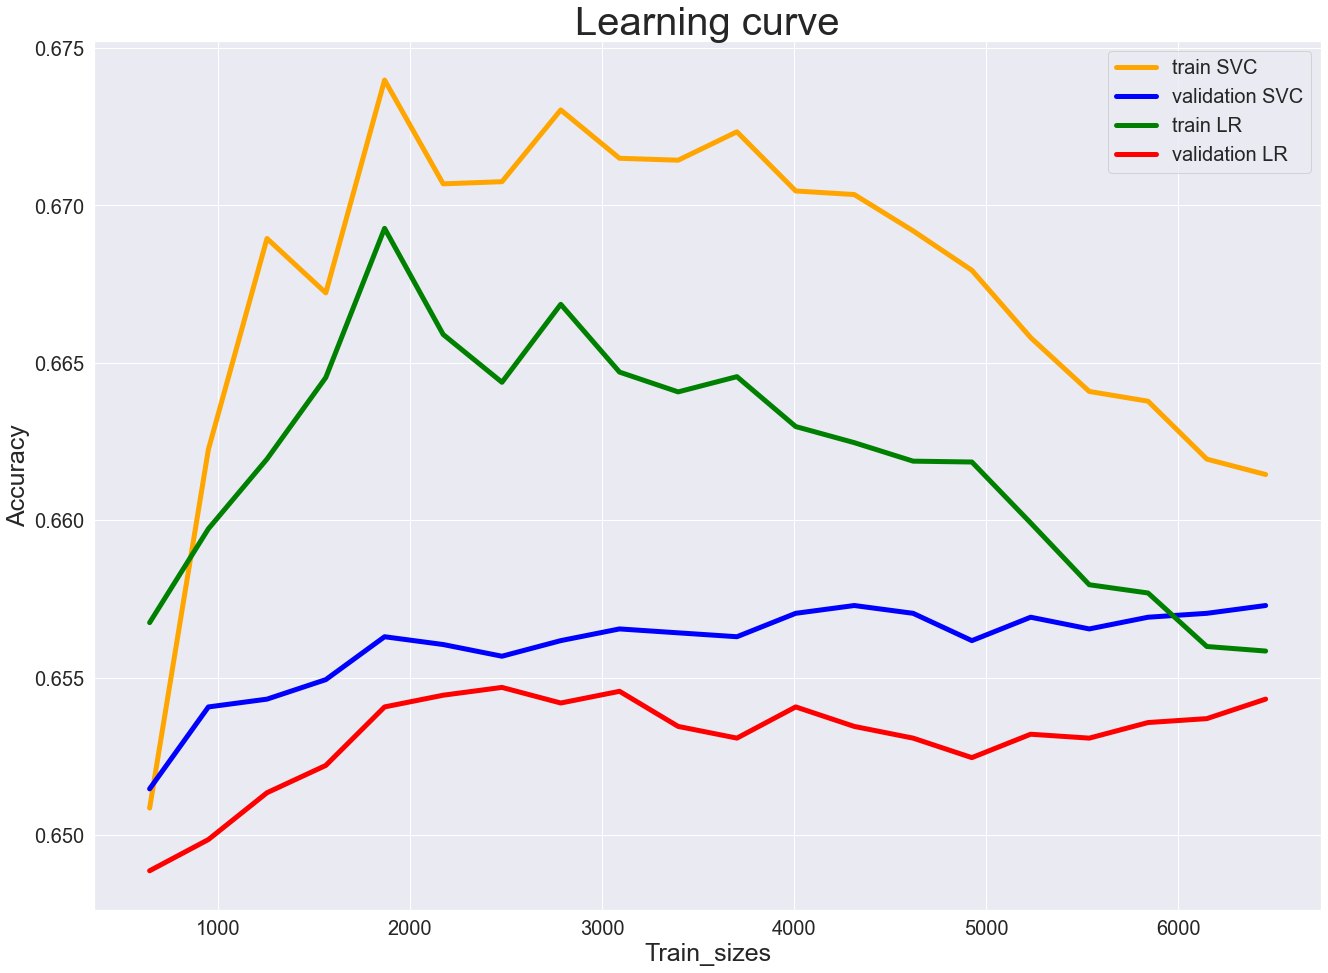

In [18]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(
    model, X_train, y_train_encoded, train_sizes = np.linspace(0.1,1.0,20), cv = 5)

NL, train_score_l, val_score_l = learning_curve(
    grid, X_train, y_train_encoded, train_sizes = np.linspace(0.1,1.0,20), cv = 5)


plt.figure(figsize = (22,16))

plt.plot(N, train_score.mean(axis = 1), label = 'train SVC', c = 'orange', linewidth=5, 
         solid_capstyle="round")
plt.plot(N, val_score.mean(axis = 1), label = 'validation SVC', c = 'blue', linewidth=5, 
         solid_capstyle="round")

plt.plot(NL, train_score_l.mean(axis = 1), label = 'train LR', c = 'green', linewidth=5, 
         solid_capstyle="round")
plt.plot(NL, val_score_l.mean(axis = 1), label = 'validation LR', c = 'red', linewidth=5, 
         solid_capstyle="round")

plt.xlabel('Train_sizes', fontsize = 25)
plt.ylabel('Accuracy', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Learning curve', fontsize = 40)
plt.legend(fontsize = 20)